In [1]:
import numpy as np
import lymph
import pandas as pd
import scipy as sp
from scipy.special import factorial
import matplotlib.pyplot as plt
import emcee                      # inference and backends for sample storage
from multiprocessing import Pool  # for parallelization of the inference


dataset_full = pd.read_csv("../lynference/data/cleaned.csv", header=[0,1,2]) #import data
dataset_USZ =  pd.read_csv("../lynference/data/cleanedUSZ.csv", header=[0,1,2]) #import data

maxllh =  dataset_USZ['max_llh']
t_stage = dataset_USZ['info']
ipsi = maxllh.loc[:,'ipsi'].drop(['IIa','IIb','VIII','Ib','IX','VI','X','Ia'],axis = 1)[['I','II','III','IV','V','VII']]
contra = maxllh.loc[:,'contra'].drop(['IIa','IIb','VIII','Ib','IX','VI','X','Ia'],axis = 1)[['I','II','III','IV','V','VII']]
ipsi_header = header = pd.MultiIndex.from_product([ ['ipsi'], ['I','II','III','IV','V','VII']], names=['', ''])
contra_header = pd.MultiIndex.from_product([['contra'], ['I','II','III','IV','V','VII']], names=['', ''])
ipsi.columns = ipsi_header
contra.columns = contra_header

dataset_analyze = pd.concat([t_stage,ipsi,contra],axis = 1)

CLB_full = dataset_full.loc[287:]
maxllh_CLB =  CLB_full['max_llh']
t_stage_CLB = CLB_full['info']
ipsi_CLB = maxllh_CLB.loc[:,'ipsi'].drop(['IIa','IIb','VIII','Ib','IX','VI','X','Ia'],axis = 1)[['I','II','III','IV','V','VII']]
contra_CLB = maxllh_CLB.loc[:,'contra'].drop(['IIa','IIb','VIII','Ib','IX','VI','X','Ia'],axis = 1)[['I','II','III','IV','V','VII']]
ipsi_header = header = pd.MultiIndex.from_product([ ['ipsi'], ['I','II','III','IV','V','VII']], names=['', ''])
contra_header = pd.MultiIndex.from_product([['contra'], ['I','II','III','IV','V','VII']], names=['', ''])
ipsi_CLB.columns = ipsi_header
contra_CLB.columns = contra_header

dataset_CLB = pd.concat([t_stage_CLB,ipsi_CLB,contra_CLB],axis = 1)

maxllh_full =  dataset_full['max_llh']
t_stage_full = dataset_full['info']
ipsi_full = maxllh_full.loc[:,'ipsi'].drop(['IIa','IIb','VIII','Ib','IX','VI','X','Ia'],axis = 1)[['I','II','III','IV','V','VII']]
contra_full = maxllh_full.loc[:,'contra'].drop(['IIa','IIb','VIII','Ib','IX','VI','X','Ia'],axis = 1)[['I','II','III','IV','V','VII']]
ipsi_header = header = pd.MultiIndex.from_product([ ['ipsi'], ['I','II','III','IV','V','VII']], names=['', ''])
contra_header = pd.MultiIndex.from_product([['contra'], ['I','II','III','IV','V','VII']], names=['', ''])
ipsi_full.columns = ipsi_header
contra_full.columns = contra_header

analysis_full = pd.concat([t_stage_full,ipsi_full,contra_full],axis = 1)
analysis_full.fillna(False, inplace=True)
(analysis_full['contra']['II'] == True).sum()
dataset_trial = pd.read_csv("../lynference/data/cleaned_trial.csv", header=[0,1,2]) #import data

In [2]:
graph = {
    ('tumor', 'primary')  : ['I','II', 'III', 'IV','V', 'VII'],
    ('lnl'  , 'I') :        ['II'],
    ('lnl'  , 'II') :       ['III'], 
    ('lnl'  , 'III'):       ['IV'], 
    ('lnl'  , 'IV') :       ['V'],
    ('lnl'  , 'V') :        [],
    ('lnl'  , 'VII') :      [],
}

model = lymph.MidlineBilateral(graph = graph,use_mixing= True, trans_symmetric =True)
model.modalities = {'CT': [0.76, 0.81],
                    'MRI': [0.63, 0.81],
                    'PET': [0.86, 0.79],
                    'FNA': [0.98, 0.80],
                    'diagnostic_consensus': [0.86, 0.81],
                    'pathology': [1.0, 1.0],
                    'pCT': [0.86, 0.81],
                    'max_llh': [1.0, 1.0]
                    }


# Time prior with p(early) = 0.3
def binom_pmf(k: np.ndarray, n: int, p: float):
    """Binomial PMF"""
    if p > 1. or p < 0.:
        raise ValueError("Binomial prob must be btw. 0 and 1")
    q = (1. - p)
    binom_coeff = factorial(n) / (factorial(k) * factorial(n - k))
    return binom_coeff * p**k * q**(n - k)

def parametric_binom_pmf(n: int):
    """Return a parametric binomial PMF"""
    def inner(t, p):
        """Parametric binomial PMF"""
        return binom_pmf(t, n, p)
    return inner

max_t = 10
model.diag_time_dists["early"] = sp.stats.binom.pmf(np.arange(max_t+1), max_t, 0.3)
model.diag_time_dists["late"] = parametric_binom_pmf(max_t)
model.patient_data = dataset_full

In [3]:
# base symmetric central
graph = {
    ('tumor', 'primary')  : ['I','II', 'III', 'IV','V', 'VII'],
    ('lnl'  , 'I') :        ['II'],
    ('lnl'  , 'II') :       ['III'], 
    ('lnl'  , 'III'):       ['IV'], 
    ('lnl'  , 'IV') :       ['V'],
    ('lnl'  , 'V') :        [],
    ('lnl'  , 'VII') :      [],
}

central = lymph.Bilateral(graph = graph,base_symmetric= True, trans_symmetric= True )
central.modalities = {'CT': [0.76, 0.81],
                    'MRI': [0.63, 0.81],
                    'PET': [0.86, 0.79],
                    'FNA': [0.98, 0.80],
                    'diagnostic_consensus': [0.86, 0.81],
                    'pathology': [1.0, 1.0],
                    'pCT': [0.86, 0.81],
                    'max_llh': [1.0, 1.0]
                    }


# Time prior with p(early) = 0.3
def binom_pmf(k: np.ndarray, n: int, p: float):
    """Binomial PMF"""
    if p > 1. or p < 0.:
        raise ValueError("Binomial prob must be btw. 0 and 1")
    q = (1. - p)
    binom_coeff = factorial(n) / (factorial(k) * factorial(n - k))
    return binom_coeff * p**k * q**(n - k)

def parametric_binom_pmf(n: int):
    """Return a parametric binomial PMF"""
    def inner(t, p):
        """Parametric binomial PMF"""
        return binom_pmf(t, n, p)
    return inner

max_t = 10
central.diag_time_dists["early"] = sp.stats.binom.pmf(np.arange(max_t+1), max_t, 0.3)
central.diag_time_dists["late"] = parametric_binom_pmf(max_t)
central.patient_data = dataset_full

In [4]:
central.modalities = {'max_llh_diagnose' : [1,0.81]}

In [5]:
midline_backend = emcee.backends.HDFBackend(filename = "../lynference/models/samples2.hdf5")
tau = 1500
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples_midline = midline_backend.get_chain(flat = True)
# model.check_and_assign(samples.mean(axis = 0))
# model.modalities = {'max_llh_diagnose' : [1,0.81]}

In [6]:
def sample_from_flattened(flattened_samples, num_samples=100, spaced=False):
    """
    Function to sample from a flattened set of MCMC samples.

    Parameters:
    - flattened_samples (np.ndarray): The flattened MCMC samples (2D array, shape [num_samples, num_parameters]).
    - num_samples (int): The number of samples to select (default is 100).
    - spaced (bool): If True, select evenly spaced samples instead of random ones (default is False).

    Returns:
    - np.ndarray: The selected samples.
    """
    if spaced:
        # Select evenly spaced samples
        step_size = flattened_samples.shape[0] // num_samples
        return flattened_samples[::step_size][:num_samples]
    else:
        # Select random samples without replacement
        indices = np.random.choice(flattened_samples.shape[0], size=num_samples, replace=False)
        return flattened_samples[indices]

len((sample_from_flattened(samples_midline, num_samples=100, spaced=True)))

100

In [7]:
def levels_to_spare_bilateral(threshold, model, risks, sampled_risks):
    """Computes which LNLs to irradiate given the threshold, model and the risk of each state.

    Args:
        threshold (float): Risk threshold we want to apply
        model (lymph.Unilateral): lymph.unilateral object with fully analyzed patients
        risks (ndarray): Array with the risk of each state

    Returns:
        _type_: _description_
    """
    state_list = model.ipsi.state_list
    lnls = ['I', 'II', 'III', 'IV', 'V', 'VII']
    overall_risk_ipsi = {}
    overall_risk_contra = {}
    for index, lnl in enumerate(lnls):
        overall_risk_ipsi[lnl] = risks[np.where((state_list[:,index] == 1))[0]].sum()
        overall_risk_contra[lnl] = risks.T[np.where((state_list[:,index] == 1))[0]].sum()

    combined_dict = {f'ipsi {key}': value for key, value in overall_risk_ipsi.items()}
    combined_dict.update({f'contra {key}': value for key, value in overall_risk_contra.items()})
    ranked_combined = sorted(combined_dict.items(), key = lambda item: item[1])
    total_risk_new = 0
    sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
    looper = 1
    treated_array = np.ones(12)
    contra_lnl_indices = []
    ipsi_lnl_indices = []
    treated_ipsi = []
    treated_contra = []
    while total_risk_new < threshold:
        sampled_total_risks = sampled_total_risks_new
        total_risk = total_risk_new
        if ipsi_lnl_indices != []:
            treated_array[ipsi_lnl_indices] = 0
        if contra_lnl_indices != []:
            treated_array[np.array(contra_lnl_indices)+6] = 0
        lnls_of_interest = ranked_combined[0:looper]
        lnls_of_interest_names = [t[0] for t in lnls_of_interest]
        contra_lnl_indices = []
        ipsi_lnl_indices = []
        for i,lnl_looper in enumerate(lnls_of_interest_names):
            contra_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0]) if lnl_looper.split()[0] == 'contra' else ipsi_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0])
        indices_list_contra = []
        indices_list_ipsi = []
        for index in contra_lnl_indices:
            condition_contra = (state_list[:, index] == 1)
            indices_contra = np.where(condition_contra)[0]
            indices_list_contra.extend(indices_contra)
            unique_contra = np.unique(indices_list_contra)
        for index in ipsi_lnl_indices:
            condition_ipsi = (state_list[:, index] == 1)
            indices_ipsi = np.where(condition_ipsi)[0]
            indices_list_ipsi.extend(indices_ipsi)
            unique_ipsi = np.unique(indices_list_ipsi)    
        if len(ipsi_lnl_indices) == 0:
            total_risk_new = risks.T[unique_contra].sum()
            sampled_total_risks_new = sampled_risks.transpose((0,2,1))[:,unique_contra].sum(axis = (1,2))
        elif len(contra_lnl_indices) == 0:
            total_risk_new = risks[unique_ipsi].sum()
            sampled_total_risks_new = sampled_risks[:,unique_ipsi].sum(axis = (1,2))
        else:
            total_risk_new = 0
            sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
            total_risk_new += risks[unique_ipsi].sum()
            total_risk_new += risks.T[unique_contra][:,[np.setdiff1d(np.array(range(64)),unique_ipsi)]].sum()
            sampled_total_risks_new += sampled_risks[:,unique_ipsi].sum(axis = (1,2))
            sampled_total_risks_new += sampled_risks.transpose((0,2,1))[:,unique_contra][:,:,list(np.setdiff1d(np.array(range(64)),unique_ipsi))].sum(axis = (1,2))

        spared_lnls = lnls_of_interest[:-1]
        treated_lnls = ranked_combined[looper-1:]
        looper += 1
    for to_treat in treated_lnls:
        if to_treat[0].split()[0] == 'ipsi':
            treated_ipsi.append(to_treat[0].split()[1])
        else: 
            treated_contra.append(to_treat[0].split()[1])
    return spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra,sampled_total_risks

In [8]:
full_USZ =  pd.read_csv("../lynference/data/2021-usz-oropharynx.csv", header=[0,1,2]) #import data
central_patients = dataset_analyze.loc[full_USZ['tumor']['1']['central']]
central_patients

tumor                     ipsi                                     \
    t_stage midline_extension      I     II    III     IV      V    VII   
18     late              True  False  False  False  False  False  False   
79     late              True  False  False  False  False  False  False   
87     late              True  False  False  False  False  False  False   
91    early              True  False  False  False  False  False  False   
144   early              True  False  False  False  False  False  False   
150    late              True  False  False  False  False  False  False   
178   early              True  False  False  False  False  False  False   
183    late              True  False  False  False  False  False  False   
207    late              True  False   True   True  False  False  False   

    contra                                     
         I     II    III     IV      V    VII  
18   False  False  False  False  False  False  
79   False   True  False  False  False  False  
87   False  False  False  False  False  False  
91   False  False  False  False  False  False  
144  False  False  False  False  False  False  
150  False  False  False  False  False  False  
178  False  False  False  False  False  False  
183  False  False  False  False  False  False  
207  False   True   True  False  False  False

In [3]:
def ci_single(sampled_risks, level=0.95):
    lower = (1 - level) / 2 * 100
    upper = 100 - lower
    ci = np.percentile(sampled_risks, [lower, upper])
    return ci


diagnose = {
    "max_llh_diagnose": {
        "ipsi": {
            "I": 0,
            "II": 1,
            "III": 0,
            "IV": 0,
            "V": 0,
            "VII": 0,
        },
        "contra": {
            "I": 0,
            "II": 0,
            "III": 0,
            "IV": 0,
            "V": 0,
            "VII": 0,
        },
    }
}
sampled_risks, risk = risk_sampled_bilateral(samples = bilateral_samples, model = central, t_stage = 'early', given_diagnoses= diagnose)
spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra, sampled_total_risks = levels_to_spare_bilateral(0.10, central, risk, sampled_risks)
print(treated_lnls)
print(total_risk*100)
print(spared_lnls)
ci_single(sampled_total_risks)*100

In [11]:
central.diag_time_dists['early'].pmf

array([2.82475249e-02, 1.21060821e-01, 2.33474441e-01, 2.66827932e-01,
       2.00120949e-01, 1.02919345e-01, 3.67569090e-02, 9.00169200e-03,
       1.44670050e-03, 1.37781000e-04, 5.90490000e-06])

In [32]:
for i, sample in enumerate(np.random.permutation(bilateral_samples[::89])):
    print(sample[-1])

0.4014894136721927
0.37814730404087343
0.34371035373122616
0.39267587745366805
0.38071083679724027
0.3356288347199717
0.4266852025109026
0.4089591742312742
0.3814444125854453
0.40373088095703374
0.39053251282232926
0.3671981309461032
0.3812642723261318
0.40934536020017526
0.3788542473262322
0.3856814157515137
0.41389395058545325
0.39785676222405936
0.38303442276034055
0.3784715269993361
0.3983754733459763
0.3860225188771191
0.38905149536865347
0.4138379265094913
0.39036395818227015
0.40388584847611525
0.39209766801052953
0.3970035934684607
0.36173549370681535
0.37844853838772036
0.39310521555970823
0.4275175242998515
0.38862862576345586
0.37268352843799535
0.38037730718336155
0.4191695540050367
0.31693212715550906
0.3542441640975648
0.38308597891783885
0.4286784250609886
0.38866707718347343
0.39581403004036736
0.4207125803360933
0.4138816147800448
0.37665160406495163
0.3678486660936283
0.37438386511027444
0.419519103310507
0.3822725316388579
0.38451263624026816
0.4021730080460709
0.379

In [21]:
indices = np.where((central.ipsi.state_list[:,3] == 1))[0]

In [22]:
risk[indices].sum()


NameError: name 'risk' is not defined

In [39]:
risk.T[indices].sum()

0.0029952009176522896

In [23]:
central.risk().shape

(64, 64)

## non central

The following code extracts the risks from our samples. thin was set to 89 which results in 214 samples/risks taken. If this number is changed, some downstream codes need to be adapted.
The mean_risk is simply the mean of the sampled risks. --> used for ranking later on

In [4]:
def risk_sampled(samples, model, t_stage, given_diagnoses, midline_extension, thin = 89):
    sampled_risks = np.zeros(shape=(len(samples[::thin]),64,64), dtype=float)
    for i, sample in enumerate(np.random.permutation(samples[::thin])):
        sampled_risks[i] = model.risk(given_params = sample, t_stage = t_stage, given_diagnoses = given_diagnoses,midline_extension=midline_extension) 
    mean_risk = sampled_risks.mean(axis = 0)
    return sampled_risks, mean_risk


Compute which levels are to be spared based on given mean risks, or sampled risks. The ranking is based on the mean risk of each state (which is equivalent to the mean risk when directly sampling the LNL involvement risk)

In [5]:
def levels_to_spare(threshold, model, risks, sampled_risks = None):
    """Computes which LNLs to irradiate given the threshold, model and the risk of each state.

    Args:
        threshold (float): Risk threshold we want to apply
        model (lymph.Midline): lymph.Midline object with fully analyzed patients
        risks (ndarray): Array with the risk of each state
        sampled_risks (ndarray): Array with sampled risks. i.e. Simply an n times risks.shape dimensional array holding several risks calculations

    Returns:
        _type_: _description_
    """
    sampled_total_risks = None
    #extract the state list. adapt to the model that is used!
    state_list = model.noext.ipsi.state_list
    lnls = []
    for lnl in model.noext.ipsi.lnls:
        lnls.append(lnl.name)
    overall_risk_ipsi = {}
    overall_risk_contra = {}
    #compute the risk for each lnl with the averaged risk array
    for index, lnl in enumerate(lnls):
        overall_risk_ipsi[lnl] = risks[np.where((state_list[:,index] == 1))[0]].sum()
        overall_risk_contra[lnl] = risks.T[np.where((state_list[:,index] == 1))[0]].sum()
    #combine both dictionaries from ipsi and contra to rank the lnls together
    combined_dict = {f'ipsi {key}': value for key, value in overall_risk_ipsi.items()}
    combined_dict.update({f'contra {key}': value for key, value in overall_risk_contra.items()})
    ranked_combined = sorted(combined_dict.items(), key = lambda item: item[1])

    #here we start extracting the risk for each lnl. with every loop we exclude a LNL from irradiation until we hit the threshold
    total_risk_new = 0
    if sampled_risks is not None and sampled_risks.size > 0:

        sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
    looper = 1
    treated_array = np.ones(12)
    contra_lnl_indices = []
    ipsi_lnl_indices = []
    treated_ipsi = []
    treated_contra = []
    while total_risk_new < threshold:
        if sampled_risks is not None and sampled_risks.size > 0:

            sampled_total_risks = sampled_total_risks_new
        total_risk = total_risk_new
        if ipsi_lnl_indices != []:
            treated_array[ipsi_lnl_indices] = 0
        if contra_lnl_indices != []:
            treated_array[np.array(contra_lnl_indices)+6] = 0
        lnls_of_interest = ranked_combined[0:looper]
        lnls_of_interest_names = [t[0] for t in lnls_of_interest]
        contra_lnl_indices = []
        ipsi_lnl_indices = []
        for i,lnl_looper in enumerate(lnls_of_interest_names):
            contra_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0]) if lnl_looper.split()[0] == 'contra' else ipsi_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0])
        indices_list_contra = []
        indices_list_ipsi = []
        for index in contra_lnl_indices:
            condition_contra = (state_list[:, index] == 1)
            indices_contra = np.where(condition_contra)[0]
            indices_list_contra.extend(indices_contra)
            unique_contra = np.unique(indices_list_contra)
        for index in ipsi_lnl_indices:
            condition_ipsi = (state_list[:, index] == 1)
            indices_ipsi = np.where(condition_ipsi)[0]
            indices_list_ipsi.extend(indices_ipsi)
            unique_ipsi = np.unique(indices_list_ipsi)    
        if len(ipsi_lnl_indices) == 0:
            total_risk_new = risks.T[unique_contra].sum()
            if sampled_risks is not None and sampled_risks.size > 0:

                sampled_total_risks_new = sampled_risks.transpose((0,2,1))[:,unique_contra].sum(axis = (1,2))
        elif len(contra_lnl_indices) == 0:
            total_risk_new = risks[unique_ipsi].sum()
            if sampled_risks is not None and sampled_risks.size > 0:

                sampled_total_risks_new = sampled_risks[:,unique_ipsi].sum(axis = (1,2))
        else:
            total_risk_new = 0
            total_risk_new += risks[unique_ipsi].sum()
            total_risk_new += risks.T[unique_contra][:,[np.setdiff1d(np.array(range(64)),unique_ipsi)]].sum()
            if sampled_risks is not None and sampled_risks.size > 0:

                sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
                sampled_total_risks_new += sampled_risks[:,unique_ipsi].sum(axis = (1,2))
                sampled_total_risks_new += sampled_risks.transpose((0,2,1))[:,unique_contra][:,:,list(np.setdiff1d(np.array(range(64)),unique_ipsi))].sum(axis = (1,2))

        spared_lnls = lnls_of_interest[:-1]
        treated_lnls = ranked_combined[looper-1:]
        looper += 1
    for to_treat in treated_lnls:
        if to_treat[0].split()[0] == 'ipsi':
            treated_ipsi.append(to_treat[0].split()[1])
        else: 
            treated_contra.append(to_treat[0].split()[1])
    return spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra,sampled_total_risks

In [6]:
model.modalities = {'max_llh_diagnose' : [1,0.81]}

In [7]:
def ci_single(sampled_risks, level = 0.95):
    lower = (1-level)/2*100
    upper = 100- lower
    ci = np.percentile(sampled_risks,[lower,upper])
    return ci
diagnose = {'max_llh_diagnose':{
    "ipsi": {
        "I": 0,
        "II": 1,
        "III": 1,
        "IV": 1,
        "V": 0,
        "VII": 0,
    },
    "contra": {
        "I": 0,
        "II": 1,
        "III": 0,
        "IV": 0,
        "V": 0,
        "VII": 0,}
}}
sampled_risks, risk = risk_sampled(samples = samples_midline, model = model, t_stage = 'early', given_diagnoses= diagnose, midline_extension= False)     
spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra, sampled_total_risks = levels_to_spare(0.10, model, risk, sampled_risks = sampled_risks)
print(treated_lnls)
print(total_risk*100)
print(spared_lnls)
ci_single(sampled_total_risks)*100

[('contra III', 0.051261804412436565), ('contra II', 0.9999999999999997), ('ipsi II', 0.9999999999999998), ('ipsi III', 0.9999999999999998), ('ipsi IV', 0.9999999999999998)]
9.680397584298941
[('contra V', 0.0006096392044835138), ('contra IV', 0.0031076098629541494), ('contra I', 0.0034442297679531564), ('contra VII', 0.0050354444328463595), ('ipsi VII', 0.01912607698040327), ('ipsi I', 0.026491282825520834), ('ipsi V', 0.042963552378365744)]


array([ 7.77202338, 11.63172726])

flat chain shape: (18000, 18)
(50, 360, 18)


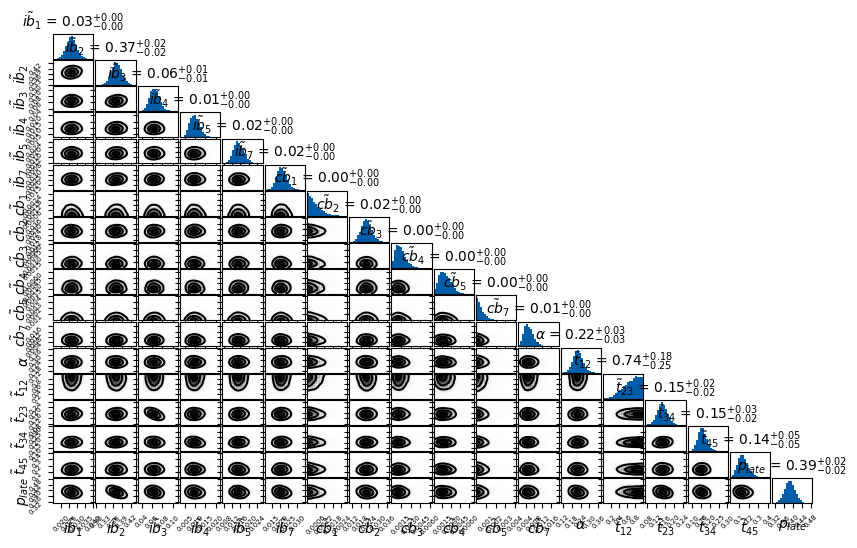

In [16]:
samples1 = midline_backend.get_chain(flat=True)
print("flat chain shape: {0}".format(samples1.shape))

# reader = emcee.backends.HDFBackend(filename = samples.hdf5, name= 'original/samples')
# reader.shape
print(midline_backend.get_chain().shape)
# ar = np.mean(original_sampler.acceptance_fraction)
# print(f"the HMM sampler accepted {ar * 100 :.2f} % of samples.")

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import font_manager
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
from cycler import cycler
import corner

# USZ colors
usz_blue = '#005ea8'
usz_green = '#00afa5'
usz_red = '#ae0060'
usz_orange = '#f17900'
usz_gray = '#c5d5db'

# colormaps
white_to_blue  = LinearSegmentedColormap.from_list("white_to_blue", 
                                                   ["#ffffff", usz_blue], 
                                                   N=256)
white_to_green = LinearSegmentedColormap.from_list("white_to_green", 
                                                   ["#ffffff", usz_green], 
                                                   N=256)
green_to_red   = LinearSegmentedColormap.from_list("green_to_red", 
                                                   [usz_green, usz_red], 
                                                   N=256)

h = usz_gray.lstrip('#')
gray_rgba = tuple(int(h[i:i+2], 16) / 255. for i in (0, 2, 4)) + (1.0,)
tmp = LinearSegmentedColormap.from_list("tmp", [usz_green, usz_red], N=128)
tmp = tmp(np.linspace(0., 1., 128))
tmp = np.vstack([np.array([gray_rgba]*128), tmp])
halfGray_halfGreenToRed = ListedColormap(tmp)


def set_size(width="single", unit="cm", ratio="golden"):
    if width == "single":
        width = 10
    elif width == "full":
        width = 20
    else:
        try:
            width = width
        except:
            width = 10
            
    if unit == "cm":
        width = width / 2.54
        
    if ratio == "golden":
        ratio = 1.618
    else:
        ratio = ratio
    
    try:
        height = width / ratio
    except:
        height = width / 1.618
        
    return (width, height)



labels = [r"$\tilde{ib}_1$", r"$\tilde{ib}_2$", r"$\tilde{ib}_3$", r"$\tilde{ib}_4$", r"$\tilde{ib}_5$", r"$\tilde{ib}_7$",
          r"$\tilde{cb}_1$", r"$\tilde{cb}_2$", r"$\tilde{cb}_3$", r"$\tilde{cb}_4$", r"$\tilde{cb}_5$", r"$\tilde{cb}_7$",r"$\alpha$",
          r"$\tilde{t}_{12}$", r"$\tilde{t}_{23}$", r"$\tilde{t}_{34}$", r"$\tilde{t}_{45}$", r"$p_{late}$"]

fig = plt.figure(figsize=set_size(width="full", ratio='golden'))
# using the corner plot package

corner.corner(samples1, labels=labels, smooth=True, fig=fig, 
              hist_kwargs={'histtype': 'stepfilled', 'color': usz_blue}, 
              **{'plot_datapoints': False, 'no_fill_contours': True, 
                 "density_cmap": white_to_blue.reversed(), 
                 "contour_kwargs": {"colors": "k"}, 
                 "levels": np.array([0.2, 0.5, 0.8])}, 
              show_titles=True, title_kwargs={"fontsize": 10},labelpad =0.25);

axes = fig.get_axes()
for ax in axes:
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=5)

# plt.savefig("../figures/CLB_and_USZ_dataset_complete_trinary", dpi=1000, bbox_inches="tight")    

## Combination analysis

In [44]:
from collections import Counter
from collections import defaultdict


# Sample array with different entry combinations
data = np.array(dataset_analyze)

entry_combinations_with_indexes = defaultdict(list)
for index, row in enumerate(data):
    combination = tuple(row)
    entry_combinations_with_indexes[combination].append(index)
USZ_counts = []
USZ_combinations = []
USZ_indexes = []
# Print the most common combinations, their USZ_counts, and indexes
for combination, indexes in entry_combinations_with_indexes.items():
    count = len(indexes)
    USZ_indexes.append(indexes)
    # print(f"Combination: {combination}, Count: {count}, Indexes: {indexes}")
    USZ_counts.append(count)
    USZ_combinations.append(combination)

lnls = ['I','II', 'III', 'IV','V', 'VII']
t_stage = []
midline_extension = []
invovlvement_ipsi_USZ = []
invovlvement_contra_USZ = []
for diagnose_type in USZ_combinations:
    involved_ipsi = []
    involved_contra = []
    t_stage.append(diagnose_type[0])
    midline_extension.append(diagnose_type[1])
    for lnl_looper, involved_level in enumerate(lnls):
        if diagnose_type[lnl_looper +2] == True:
            involved_ipsi.append(involved_level) 
        if diagnose_type[lnl_looper +8] == True:
            involved_contra.append(involved_level)
    invovlvement_ipsi_USZ.append(involved_ipsi)
    invovlvement_contra_USZ.append(involved_contra)

In [41]:
# df2 = pd.DataFrame(USZ_combinations)
# df2.to_csv('involvement_combinations_USZ.csv')

Here we havethe code to compute the treated lnls. The code samples the risk of involvement given a diagnose and outputs all samples. Which allows us to build confidence intervals

In [159]:
backend1 = emcee.backends.HDFBackend(filename = "../lynference/models/samples2.hdf5") #this one seems to be the samples for the midline model --> QUITE SURE
samples1 = backend1.get_chain(flat=True)

print(samples1.shape)


(18000, 18)


In [48]:
def analysis_treated_lnls_sampled(combinations):
    treatment_array = np.zeros((len(combinations),12))
    top3_spared = []
    diagnose_looper = {'max_llh_diagnose':{
        "ipsi": {
            "I": 0,
            "II": 0,
            "III": 0,
            "IV": 0,
            "V": 0,
            "VII": 0,
        },
        "contra": {
            "I": 0,
            "II": 0,
            "III": 0,
            "IV": 0,
            "V": 0,
            "VII": 0,
        }
    }}
    treated_lnls_all = []
    treated_lnls_no_risk = []
    total_risks = np.zeros(len(combinations))
    sampled_risks_array = np.zeros((len(combinations),203))
    treated_ipsi_all = []
    treated_contra_all = []
    for index, pattern in enumerate(combinations):
        treated_looper = set()
        stage = pattern[0]
        midline_extension = pattern[1]
        counter_ipsi = 0
        for lnl_ipsi, status in diagnose_looper['max_llh_diagnose']['ipsi'].items():
            diagnose_looper['max_llh_diagnose']['ipsi'][lnl_ipsi] = pattern[2+counter_ipsi]
            counter_ipsi += 1
        counter_contra = 0
        for lnl_contra, status in diagnose_looper['max_llh_diagnose']['contra'].items():
            diagnose_looper['max_llh_diagnose']['contra'][lnl_contra] = pattern[8+counter_contra]
            counter_contra += 1
        sampled_risks, mean_risk = risk_sampled(samples = samples_midline, model = model, t_stage = stage, given_diagnoses=diagnose_looper,midline_extension=midline_extension)     
        spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra, sampled_total_risks =levels_to_spare(0.10, model, mean_risk, sampled_risks)
        for i in treated_lnls:
            treated_looper.add(i[0])
        treated_lnls_all.append(treated_lnls)
        treated_lnls_no_risk.append(treated_looper)
        treatment_array[index] = treated_array
        total_risks[index] = total_risk
        sampled_risks_array[index] = sampled_total_risks
        top3_spared.append(spared_lnls[::-1][:3])
        treated_ipsi_all.append(treated_ipsi)
        treated_contra_all.append(treated_contra)
    return treated_lnls_no_risk, treated_lnls_all, treatment_array, top3_spared, total_risks, treated_ipsi_all, treated_contra_all, sampled_risks_array





def count_number_treatments(treated_lnls_no_risk):
    set_counts = {}
    # Iterate through the list and update the counts in the dictionary
    for value in treated_lnls_no_risk:
        frozen_set = frozenset(value)  # Convert the set to a frozenset
        if frozen_set in set_counts:
            set_counts[frozen_set] += 1
        else:
            set_counts[frozen_set] = 1
    return set_counts


In [49]:
usz_treated_lnls_no_risk, usz_treated_lnls_all, usz_treatment_array, usz_top3_spared, usz_total_risks, usz_treated_ipsi, usz_treated_contra, usz_sampled_risks_array = analysis_treated_lnls_sampled(USZ_combinations)
usz_set_counts = count_number_treatments(usz_treated_lnls_no_risk)
len(usz_set_counts)

38

The following code computes the CIs for our sampled risks by taking the equal tailed interval

In [59]:
def ci_calculator(sampled_risks,level = 0.95):
    lower = (1-level)/2*100
    upper = 100- lower
    ci = np.zeros((77,2))
    for index in range(77):
        ci[index] = np.percentile(sampled_risks[index],[lower,upper])
    return ci


In [57]:
ci = ci_calculator(usz_sampled_risks_array)

In [58]:
df = pd.DataFrame(usz_treatment_array)
df.to_csv('treatment_array_010_new.csv')

data_export_usz = pd.DataFrame({'Percentage of patients': np.array(USZ_counts)/287,
                                'T-stage': t_stage,
                                'Midline Extension': midline_extension,
                                'Involvement Ipsi' : invovlvement_ipsi_USZ,
                                'Involvement Contra': invovlvement_contra_USZ,
                                'Treated Ipsi':  usz_treated_ipsi,
                                'Treated Contra': usz_treated_contra,
                                'risk': usz_total_risks,
                                'lower bound': ci.T[0],
                                'upper bound': ci.T[1],
                                'top 3 spared lnls risk': usz_top3_spared

})
data_export_usz.to_csv('analyzed_usz_data_new_graph_010_new_dataset.csv', sep = ';', index = False)

In [60]:
number_of_repetitions = []
for key, value in usz_set_counts.items():
    number_of_repetitions.append(value)
usz_set_counts[frozenset({'ipsi II'})]
asdf = (np.array(USZ_combinations) == ['late',False,False,True,False,False,False,False,False,False,False,False,False,False,])
# Define the condition (e.g., all 'True' values)
condition = (asdf[:, 1:] == 'True').all(axis=1)

# Find indices where the condition is met
indices = np.where(condition)

print(indices)

KeyError: frozenset({'ipsi II'})

## analysis for the trial dataset

In [69]:
dataset_trial['max_llh']

ipsi                                                            ...  \
       X  IX    III      V VIII     IV     Ib    IIb    IIa      I  ...   
0    NaN NaN  False  False  NaN  False  False   True   True  False  ...   
1    NaN NaN  False  False  NaN  False  False  False   True  False  ...   
2    NaN NaN   True  False  NaN   True   True  False   True   True  ...   
3    NaN NaN   True  False  NaN   True  False   True   True  False  ...   
4    NaN NaN  False  False  NaN  False  False  False   True  False  ...   
..   ...  ..    ...    ...  ...    ...    ...    ...    ...    ...  ...   
593  NaN NaN  False  False  NaN  False  False  False   True  False  ...   
594  NaN NaN  False  False  NaN  False  False  False  False  False  ...   
595  NaN NaN   True   True  NaN  False  False  False   True  False  ...   
596  NaN NaN  False  False  NaN  False  False  False  False  False  ...   
597  NaN NaN   True  False  NaN  False  False  False  False  False  ...   

    contra                                                              
        Ib    IIb    IIa      I    VII     Vb     II  VI     Ia     Va  
0    False  False  False  False  False    NaN  False NaN  False    NaN  
1    False  False   True  False  False    NaN   True NaN  False    NaN  
2     True  False   True   True  False    NaN   True NaN  False    NaN  
3    False  False  False  False  False    NaN  False NaN  False    NaN  
4    False  False  False  False  False    NaN  False NaN  False    NaN  
..     ...    ...    ...    ...    ...    ...    ...  ..    ...    ...  
593  False  False  False  False    NaN  False  False NaN  False  False  
594  False  False  False  False    NaN  False  False NaN  False  False  
595  False  False  False  False    NaN  False  False NaN  False  False  
596  False  False  False  False    NaN  False  False NaN  False  False  
597  False  False  False  False    NaN  False  False NaN  False  False  

[598 rows x 32 columns]

In [73]:
maxllh_trial =  dataset_trial['max_llh']
t_stage_trial = dataset_trial['info']
ipsi_trial = maxllh_trial.loc[:,'ipsi'].drop(['IIa','IIb','VIII','Ib','IX','VI','X','Ia'],axis = 1)[['I','II','III','IV','V','VII']]
contra_trial = maxllh_trial.loc[:,'contra'].drop(['IIa','IIb','VIII','Ib','IX','VI','X','Ia'],axis = 1)[['I','II','III','IV','V','VII']]
ipsi_header = header = pd.MultiIndex.from_product([ ['ipsi'], ['I','II','III','IV','V','VII']], names=['', ''])
contra_header = pd.MultiIndex.from_product([['contra'], ['I','II','III','IV','V','VII']], names=['', ''])
ipsi_trial.columns = ipsi_header
contra_trial.columns = contra_header

dataset_trial = pd.concat([t_stage_trial,ipsi_trial,contra_trial],axis = 1)

In [74]:
dataset_trial

tumor                     ipsi                                     \
    t_stage midline_extension      I     II    III     IV      V    VII   
0      late              True  False   True  False  False  False  False   
1     early             False  False   True  False  False  False  False   
2      late              True   True   True   True   True  False   True   
3      late              True  False   True   True   True  False   True   
4     early             False  False   True  False  False  False   True   
..      ...               ...    ...    ...    ...    ...    ...    ...   
593    late             False  False   True  False  False  False    NaN   
594   early             False  False  False  False  False  False    NaN   
595    late             False  False   True   True  False   True    NaN   
596   early             False  False  False  False  False  False    NaN   
597   early             False  False  False   True  False  False    NaN   

    contra                                     
         I     II    III     IV      V    VII  
0    False  False  False  False  False  False  
1    False   True  False  False  False  False  
2     True   True   True   True  False  False  
3    False  False  False  False  False  False  
4    False  False  False  False  False  False  
..     ...    ...    ...    ...    ...    ...  
593  False  False  False  False  False    NaN  
594  False  False  False  False  False    NaN  
595  False  False  False  False  False    NaN  
596  False  False  False  False  False    NaN  
597  False  False  False  False  False    NaN  

[598 rows x 14 columns]

In [81]:
# Sample array with different entry combinations
data_trial = np.array(dataset_trial)

entry_combinations_with_indexes = defaultdict(list)
for index, row in enumerate(data_trial):
    combination = tuple(row)
    entry_combinations_with_indexes[combination].append(index)
trial_counts = []
trial_combinations = []
trial_indexes = []
# Print the most common combinations, their trial_counts, and indexes
for combination, indexes in entry_combinations_with_indexes.items():
    count = len(indexes)
    trial_indexes.append(indexes)
    # print(f"Combination: {combination}, Count: {count}, Indexes: {indexes}")
    trial_counts.append(count)
    trial_combinations.append(combination)

lnls = ['I','II', 'III', 'IV','V', 'VII']
t_stage = []
midline_extension = []
involvement_ipsi_trial = []
involvement_contra_trial = []
for diagnose_type in trial_combinations:
    involved_ipsi = []
    involved_contra = []
    t_stage.append(diagnose_type[0])
    midline_extension.append(diagnose_type[1])
    for lnl_looper, involved_level in enumerate(lnls):
        if diagnose_type[lnl_looper +2] == True:
            involved_ipsi.append(involved_level) 
        if diagnose_type[lnl_looper +8] == True:
            involved_contra.append(involved_level)
    involvement_ipsi_trial.append(involved_ipsi)
    involvement_contra_trial.append(involved_contra)

In [86]:
trial_treated_lnls_no_risk, trial_treated_lnls_all, trial_treatment_array, trial_top3_spared, trial_total_risks, trial_treated_ipsi, trial_treated_contra, trial_sampled_risks_array = analysis_treated_lnls_sampled(trial_combinations)
trial_set_counts = count_number_treatments(trial_treated_lnls_no_risk)
len(trial_set_counts)

37

In [102]:
ci_calculator(trial_sampled_risks_array)

array([[0.04083695, 0.05870993],
       [0.0521766 , 0.08114082],
       [0.02220879, 0.08064845],
       [0.02870029, 0.04622184],
       [0.02943968, 0.04530673],
       [0.07973948, 0.11987728],
       [0.06528752, 0.0824498 ],
       [0.02805569, 0.04607427],
       [0.08236714, 0.11801042],
       [0.04011727, 0.05796138],
       [0.03826831, 0.05684621],
       [0.03928853, 0.0562223 ],
       [0.06270682, 0.14760626],
       [0.08093637, 0.1211892 ],
       [0.06182272, 0.09518152],
       [0.04624929, 0.06558221],
       [0.04165699, 0.06122475],
       [0.0688462 , 0.1357077 ],
       [0.07431637, 0.11482919],
       [0.02750385, 0.04406383],
       [0.06646788, 0.10270436],
       [0.03535305, 0.05487952],
       [0.05701507, 0.09534379],
       [0.01304215, 0.02921822],
       [0.04824631, 0.07003142],
       [0.03647181, 0.05525237],
       [0.03348334, 0.05256013],
       [0.03125319, 0.05546039],
       [0.0577353 , 0.13553121],
       [0.06150819, 0.09480482],
       [0.

In [117]:
def ci_calculator(sampled_risks,level = 0.95):
    lower = (1-level)/2*100
    upper = 100- lower
    ci = np.zeros((len(sampled_risks),2))
    for index in range(len(sampled_risks)):
        ci[index] = np.percentile(sampled_risks[index],[lower,upper])
    return ci


In [119]:
ci_trial = ci_calculator(trial_sampled_risks_array)
df = pd.DataFrame(trial_treatment_array)
# df.to_csv('treatment_array_010_new.csv')

data_export_trial = pd.DataFrame({'Percentage of patients': np.array(trial_counts)/len(dataset_trial),
                                'T-stage': t_stage,
                                'Midline Extension': midline_extension,
                                'Involvement Ipsi' : involvement_ipsi_trial,
                                'Involvement Contra': involvement_contra_trial,
                                'Treated Ipsi':  trial_treated_ipsi,
                                'Treated Contra': trial_treated_contra,
                                'risk': trial_total_risks,
                                'lower bound': ci_trial.T[0],
                                'upper bound': ci_trial.T[1],
                                'top 3 spared lnls risk': trial_top3_spared

})
data_export_trial.to_csv('analyzed_trial_new_dataset.csv', sep = ';', index = False)

## Here we repeat the analysis for the CLB dataset


In [62]:
# Sample array with different entry combinations
data_CLB = np.array(dataset_CLB)

entry_combinations_with_indexes = defaultdict(list)
for index, row in enumerate(data_CLB):
    combination = tuple(row)
    entry_combinations_with_indexes[combination].append(index)
CLB_counts = []
CLB_combinations = []
CLB_indexes = []
# Print the most common combinations, their CLB_counts, and indexes
for combination, indexes in entry_combinations_with_indexes.items():
    count = len(indexes)
    CLB_indexes.append(indexes)
    # print(f"Combination: {combination}, Count: {count}, Indexes: {indexes}")
    CLB_counts.append(count)
    CLB_combinations.append(combination)

lnls = ['I','II', 'III', 'IV','V', 'VII']
t_stage = []
midline_extension = []
involvement_ipsi_CLB = []
involvement_contra_CLB = []
for diagnose_type in CLB_combinations:
    involved_ipsi = []
    involved_contra = []
    t_stage.append(diagnose_type[0])
    midline_extension.append(diagnose_type[1])
    for lnl_looper, involved_level in enumerate(lnls):
        if diagnose_type[lnl_looper +2] == True:
            involved_ipsi.append(involved_level) 
        if diagnose_type[lnl_looper +8] == True:
            involved_contra.append(involved_level)
    involvement_ipsi_CLB.append(involved_ipsi)
    involvement_contra_CLB.append(involved_contra)

In [63]:
clb_treated_lnls_no_risk, clb_treated_lnls_all, clb_treatment_array, clb_top3_spared, clb_total_risks, clb_treated_ipsi, clb_treated_contra, clb_sampled_risks_array = analysis_treated_lnls_sampled(CLB_combinations)
clb_set_counts = count_number_treatments(clb_treated_lnls_no_risk)
len(clb_set_counts)

18

In [64]:
len(clb_treated_contra)

69

In [87]:
def ci_calculator(sampled_risks,level = 0.95):
    lower = (1-level)/2*100
    upper = 100- lower
    ci = np.zeros((69,2))
    for index in range(69):
        ci[index] = np.percentile(sampled_risks[index],[lower,upper])
    return ci


In [65]:
ci_clb = ci_calculator(clb_sampled_risks_array)
df = pd.DataFrame(clb_treatment_array)
df.to_csv('treatment_array_010_new.csv')

data_export_clb = pd.DataFrame({'Percentage of patients': np.array(CLB_counts)/263,
                                'T-stage': t_stage,
                                'Midline Extension': midline_extension,
                                'Involvement Ipsi' : involvement_ipsi_CLB,
                                'Involvement Contra': involvement_contra_CLB,
                                'Treated Ipsi':  clb_treated_ipsi,
                                'Treated Contra': clb_treated_contra,
                                'risk': clb_total_risks,
                                'lower bound': ci_clb.T[0],
                                'upper bound': ci_clb.T[1],
                                'top 3 spared lnls risk': clb_top3_spared

})
data_export_clb.to_csv('analyzed_clb_data_010_new.csv', sep = ';', index = False)

## Combined USZ and CLB analysis

In [121]:
# Sample array with different entry combinations
data_full = np.array(analysis_full)

entry_combinations_with_indexes = defaultdict(list)
for index, row in enumerate(data_full):
    combination = tuple(row)
    entry_combinations_with_indexes[combination].append(index)
full_counts = []
full_combinations = []
full_indexes = []
# Print the most common combinations, their full_counts, and indexes
for combination, indexes in entry_combinations_with_indexes.items():
    count = len(indexes)
    full_indexes.append(indexes)
    # print(f"Combination: {combination}, Count: {count}, Indexes: {indexes}")
    full_counts.append(count)
    full_combinations.append(combination)

lnls = ['I','II', 'III', 'IV','V', 'VII']
t_stage = []
midline_extension = []
involvement_ipsi_full = []
involvement_contra_full = []
for diagnose_type in full_combinations:
    involved_ipsi = []
    involved_contra = []
    t_stage.append(diagnose_type[0])
    midline_extension.append(diagnose_type[1])
    for lnl_looper, involved_level in enumerate(lnls):
        if diagnose_type[lnl_looper +2] == True:
            involved_ipsi.append(involved_level) 
        if diagnose_type[lnl_looper +8] == True:
            involved_contra.append(involved_level)
    involvement_ipsi_full.append(involved_ipsi)
    involvement_contra_full.append(involved_contra)

In [122]:
full_treated_lnls_no_risk, full_treated_lnls_all, full_treatment_array, full_top3_spared, full_total_risks, full_treated_ipsi, full_treated_contra, full_sampled_risks_array = analysis_treated_lnls_sampled(full_combinations)
full_set_counts = count_number_treatments(full_treated_lnls_no_risk)
len(full_set_counts)

30

In [123]:
len(full_treated_ipsi)

112

In [124]:
def ci_calculator(sampled_risks,level = 0.95):
    lower = (1-level)/2*100
    upper = 100- lower
    ci = np.zeros((112,2))
    for index in range(112):
        ci[index] = np.percentile(sampled_risks[index],[lower,upper])
    return ci


In [126]:
ci_full = ci_calculator(full_sampled_risks_array)
df = pd.DataFrame(full_treatment_array)
df.to_csv('treatment_array_new_dataset.csv')

data_export_full = pd.DataFrame({'Percentage of patients': np.array(full_counts)/len(analysis_full),
                                'T-stage': t_stage,
                                'Midline Extension': midline_extension,
                                'Involvement Ipsi' : involvement_ipsi_full,
                                'Involvement Contra': involvement_contra_full,
                                'Treated Ipsi':  full_treated_ipsi,
                                'Treated Contra': full_treated_contra,
                                'risk': full_total_risks,
                                'lower bound': ci_full.T[0],
                                'upper bound': ci_full.T[1],
                                'top 3 spared lnls risk': full_top3_spared

})
data_export_full.to_csv('analyzed_new_dataset.csv', sep = ';', index = False)

## new version try 05.03.2025


risk tables


In [51]:
sampled_risks_early_no_ext = np.zeros(shape=(len(samples_midline[::89]),64,64), dtype=float)
sampled_risks_early_ext = np.zeros(shape=(len(samples_midline[::89]),64,64), dtype=float)
sampled_risks_late_no_ext = np.zeros(shape=(len(samples_midline[::89]),64,64), dtype=float)
sampled_risks_late_ext = np.zeros(shape=(len(samples_midline[::89]),64,64), dtype=float)
for i, sample in enumerate(np.random.permutation(samples_midline[::89])):
    sampled_risks_early_no_ext[i] = model.risk(given_params = sample, t_stage = 'early' ,midline_extension=False) 
    sampled_risks_early_ext[i] = model.risk(given_params = sample, t_stage = 'early', midline_extension=True)
    sampled_risks_late_no_ext[i] = model.risk(given_params = sample, t_stage = 'late',midline_extension=False)
    sampled_risks_late_ext[i] = model.risk(given_params = sample, t_stage = 'late',midline_extension=True)

mean_risk_early_no_ext = sampled_risks_early_no_ext.mean(axis = 0)
mean_risk_early_ext = sampled_risks_early_ext.mean(axis = 0)
mean_risk_late_no_ext = sampled_risks_late_no_ext.mean(axis = 0)
mean_risk_late_ext = sampled_risks_late_ext.mean(axis = 0)

In [52]:
state_list = model.noext.ipsi.state_list
state_list_names = []
for index, state in enumerate(state_list):
    state_list_names.append(str(state))
df_early_no_ext = pd.DataFrame(mean_risk_early_no_ext, columns=state_list_names, index=state_list_names)
df_early_ext = pd.DataFrame(mean_risk_early_ext, columns=state_list_names, index=state_list_names)
df_late_no_ext = pd.DataFrame(mean_risk_late_no_ext, columns=state_list_names, index=state_list_names)
df_late_ext = pd.DataFrame(mean_risk_late_ext, columns=state_list_names, index=state_list_names)

df_early_no_ext.to_excel('early_no_ext.xlsx')
df_early_ext.to_excel('early_ext.xlsx')
df_late_no_ext.to_excel('late_no_ext.xlsx')
df_late_ext.to_excel('late_ext.xlsx')

In [53]:
def levels_to_spare2(threshold, model, risks, sampled_risks):
    """Computes which LNLs to irradiate given the threshold, model and the risk of each state.

    Args:
        threshold (float): Risk threshold we want to apply
        model (lymph.Unilateral): lymph.unilateral object with fully analyzed patients
        risks (ndarray): Array with the risk of each state

    Returns:
        _type_: _description_
    """
    state_list = model.noext.ipsi.state_list
    lnls = ['I', 'II', 'III', 'IV', 'V', 'VII']
    overall_risk_ipsi = {}
    overall_risk_contra = {}
    for index, lnl in enumerate(lnls):
        overall_risk_ipsi[lnl] = risks[np.where((state_list[:,index] == 1))[0]].sum()
        overall_risk_contra[lnl] = risks.T[np.where((state_list[:,index] == 1))[0]].sum()

    combined_dict = {f'ipsi {key}': value for key, value in overall_risk_ipsi.items()}
    combined_dict.update({f'contra {key}': value for key, value in overall_risk_contra.items()})
    ranked_combined = sorted(combined_dict.items(), key = lambda item: item[1])
    total_risk_new = 0
    sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
    looper = 1
    treated_array = np.ones(12)
    contra_lnl_indices = []
    ipsi_lnl_indices = []
    treated_ipsi = []
    treated_contra = []
    while total_risk_new < threshold:
        sampled_total_risks = sampled_total_risks_new
        total_risk = total_risk_new
        if ipsi_lnl_indices != []:
            treated_array[ipsi_lnl_indices] = 0
        if contra_lnl_indices != []:
            treated_array[np.array(contra_lnl_indices)+6] = 0
        lnls_of_interest = ranked_combined[0:looper]
        lnls_of_interest_names = [t[0] for t in lnls_of_interest]
        contra_lnl_indices = []
        ipsi_lnl_indices = []
        for i,lnl_looper in enumerate(lnls_of_interest_names):
            contra_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0]) if lnl_looper.split()[0] == 'contra' else ipsi_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0])
        indices_list_contra = []
        indices_list_ipsi = []
        for index in contra_lnl_indices:
            condition_contra = (state_list[:, index] == 1)
            indices_contra = np.where(condition_contra)[0]
            indices_list_contra.extend(indices_contra)
            unique_contra = np.unique(indices_list_contra)
        for index in ipsi_lnl_indices:
            condition_ipsi = (state_list[:, index] == 1)
            indices_ipsi = np.where(condition_ipsi)[0]
            indices_list_ipsi.extend(indices_ipsi)
            unique_ipsi = np.unique(indices_list_ipsi)    
        if len(ipsi_lnl_indices) == 0:
            total_risk_new = risks.T[unique_contra].sum()
            sampled_total_risks_new = sampled_risks.transpose((0,2,1))[:,unique_contra].sum(axis = (1,2))
        elif len(contra_lnl_indices) == 0:
            total_risk_new = risks[unique_ipsi].sum()
            sampled_total_risks_new = sampled_risks[:,unique_ipsi].sum(axis = (1,2))
        else:
            total_risk_new = 0
            sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
            total_risk_new += risks[unique_ipsi].sum()
            total_risk_new += risks.T[unique_contra][:,[np.setdiff1d(np.array(range(64)),unique_ipsi)]].sum()
            sampled_total_risks_new += sampled_risks[:,unique_ipsi].sum(axis = (1,2))
            sampled_total_risks_new += sampled_risks.transpose((0,2,1))[:,unique_contra][:,:,list(np.setdiff1d(np.array(range(64)),unique_ipsi))].sum(axis = (1,2))
        spared_lnls = lnls_of_interest[:-1]
        treated_lnls = ranked_combined[looper-1:]
        looper += 1
    for to_treat in treated_lnls:
        if to_treat[0].split()[0] == 'ipsi':
            treated_ipsi.append(to_treat[0].split()[1])
        else: 
            treated_contra.append(to_treat[0].split()[1])
    return spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra,sampled_total_risks

In [54]:
def ci_single2(sampled_risks, level = 0.95):
    lower = (1-level)/2*100
    upper = 100- lower
    ci = np.percentile(sampled_risks,[lower,upper])
    return ci
diagnose = {"ipsi": {'max_llh_diagnose':{
        "I": 0,
        "II": 0,
        "III": 0,
        "IV": 0,
        "V": 0,
        "VII": 0
    }},
    "contra": {'max_llh_diagnose':{
        "I": 0,
        "II": 1,
        "III": 0,
        "IV": 0,
        "V": 0,
        "VII": 0
    }}}

In [55]:
#NOTE This function adds the highest LNL when the threshold is surpassed by the upper CI bound. However the risk is not recalculated! Thus the treatment that is proposed is already with the next LNL included, the risk is therefor not the risk when this LNL is also treated, but the risk when we treat one LNL less.
def levels_to_spare_ci2(threshold, model, risks, sampled_risks):
    """Computes which LNLs to irradiate given the threshold, model and the risk of each state.

    Args:
        threshold (float): Risk threshold we want to apply
        model (lymph.Unilateral): lymph.unilateral object with fully analyzed patients
        risks (ndarray): Array with the risk of each state

    Returns:
        _type_: _description_
    """
    state_list = model.noext.ipsi.state_list
    lnls = ['I', 'II', 'III', 'IV', 'V', 'VII']
    overall_risk_ipsi = {}
    overall_risk_contra = {}
    for index, lnl in enumerate(lnls):
        overall_risk_ipsi[lnl] = risks[np.where((state_list[:,index] == 1))[0]].sum()
        overall_risk_contra[lnl] = risks.T[np.where((state_list[:,index] == 1))[0]].sum()

    combined_dict = {f'ipsi {key}': value for key, value in overall_risk_ipsi.items()}
    combined_dict.update({f'contra {key}': value for key, value in overall_risk_contra.items()})
    ranked_combined = sorted(combined_dict.items(), key = lambda item: item[1])
    total_risk_new = 0
    sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
    looper = 1
    treated_array = np.ones(12)
    contra_lnl_indices = []
    ipsi_lnl_indices = []
    treated_ipsi = []
    treated_contra = []
    while total_risk_new < threshold and looper < len(lnls)*2+2:
        sampled_total_risks = sampled_total_risks_new
        total_risk = total_risk_new
        if ipsi_lnl_indices != []:
            treated_array[ipsi_lnl_indices] = 0
        if contra_lnl_indices != []:
            treated_array[np.array(contra_lnl_indices)+6] = 0
        lnls_of_interest = ranked_combined[0:looper]
        lnls_of_interest_names = [t[0] for t in lnls_of_interest]
        contra_lnl_indices = []
        ipsi_lnl_indices = []
        for i,lnl_looper in enumerate(lnls_of_interest_names):
            contra_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0]) if lnl_looper.split()[0] == 'contra' else ipsi_lnl_indices.append(np.where(np.array(lnls) == lnls_of_interest_names[i].split()[1])[0][0])
        indices_list_contra = []
        indices_list_ipsi = []
        for index in contra_lnl_indices:
            condition_contra = (state_list[:, index] == 1)
            indices_contra = np.where(condition_contra)[0]
            indices_list_contra.extend(indices_contra)
            unique_contra = np.unique(indices_list_contra)
        for index in ipsi_lnl_indices:
            condition_ipsi = (state_list[:, index] == 1)
            indices_ipsi = np.where(condition_ipsi)[0]
            indices_list_ipsi.extend(indices_ipsi)
            unique_ipsi = np.unique(indices_list_ipsi)    
        if len(ipsi_lnl_indices) == 0:
            total_risk_new = risks.T[unique_contra].sum()
            sampled_total_risks_new = sampled_risks.transpose((0,2,1))[:,unique_contra].sum(axis = (1,2))
        elif len(contra_lnl_indices) == 0:
            total_risk_new = risks[unique_ipsi].sum()
            sampled_total_risks_new = sampled_risks[:,unique_ipsi].sum(axis = (1,2))
        else:
            total_risk_new = 0
            sampled_total_risks_new = np.zeros(sampled_risks.shape[0])
            total_risk_new += risks[unique_ipsi].sum()
            total_risk_new += risks.T[unique_contra][:,[np.setdiff1d(np.array(range(64)),unique_ipsi)]].sum()
            sampled_total_risks_new += sampled_risks[:,unique_ipsi].sum(axis = (1,2))
            sampled_total_risks_new += sampled_risks.transpose((0,2,1))[:,unique_contra][:,:,list(np.setdiff1d(np.array(range(64)),unique_ipsi))].sum(axis = (1,2))
        if ci_single(sampled_total_risks)[1] > threshold:
            spared_lnls = lnls_of_interest[:-2]
            treated_lnls = ranked_combined[looper-2:]
        else:
            spared_lnls = lnls_of_interest[:-1]
            treated_lnls = ranked_combined[looper-1:]
        looper += 1
        print(looper,treated_lnls)
    for to_treat in treated_lnls:
        if to_treat[0].split()[0] == 'ipsi':
            treated_ipsi.append(to_treat[0].split()[1])
        else: 
            treated_contra.append(to_treat[0].split()[1])
    return spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra,sampled_total_risks

In [56]:
def analysis_treated_lnls_sampled2(combinations, samples) :
    treatment_array = np.zeros((len(combinations),12))
    top3_spared = []
    diagnose_looper = {'max_llh_diagnose':{
        "ipsi": {
            "I": 0,
            "II": 0,
            "III": 0,
            "IV": 0,
            "V": 0,
            "VII": 0,
        },
        "contra": {
            "I": 0,
            "II": 0,
            "III": 0,
            "IV": 0,
            "V": 0,
            "VII": 0,
        }
    }}
    treated_lnls_all = []
    treated_lnls_no_risk = []
    total_risks = np.zeros(len(combinations))
    sampled_risks_array = np.zeros((len(combinations),203))
    treated_ipsi_all = []
    treated_contra_all = []
    for index, pattern in enumerate(combinations):
        treated_looper = set()
        stage = pattern[0]
        midline_extension = pattern[1]
        counter_ipsi = 0
        for lnl_ipsi, status in diagnose_looper['max_llh_diagnose']['ipsi'].items():
            diagnose_looper['max_llh_diagnose']['ipsi'][lnl_ipsi] = pattern[2+counter_ipsi]
            counter_ipsi += 1
        counter_contra = 0
        for lnl_contra, status in diagnose_looper['max_llh_diagnose']['contra'].items():
            diagnose_looper['max_llh_diagnose']['contra'][lnl_contra] = pattern[8+counter_contra]
            counter_contra += 1
        print(index)
        print(diagnose_looper)
        sampled_risks, mean_risk = risk_sampled(samples = samples, model = model, t_stage = stage, given_diagnoses=diagnose_looper,midline_extension=midline_extension)  
        spared_lnls, total_risk, ranked_combined, treated_lnls, treated_array, treated_ipsi, treated_contra, sampled_total_risks =levels_to_spare_ci2(0.10, model, mean_risk, sampled_risks)
        for i in treated_lnls:
            treated_looper.add(i[0])
        treated_lnls_all.append(treated_lnls)
        treated_lnls_no_risk.append(treated_looper)
        treatment_array[index] = treated_array
        total_risks[index] = total_risk
        sampled_risks_array[index] = sampled_total_risks
        top3_spared.append(spared_lnls[::-1][:3])
        treated_ipsi_all.append(treated_ipsi)
        treated_contra_all.append(treated_contra)
    return treated_lnls_no_risk, treated_lnls_all, treatment_array, top3_spared, total_risks, treated_ipsi_all, treated_contra_all, sampled_risks_array





def count_number_treatments2(treated_lnls_no_risk):
    set_counts = {}
    # Iterate through the list and update the counts in the dictionary
    for value in treated_lnls_no_risk:
        frozen_set = frozenset(value)  # Convert the set to a frozenset
        if frozen_set in set_counts:
            set_counts[frozen_set] += 1
        else:
            set_counts[frozen_set] = 1
    return set_counts

def ci_calculator2(sampled_risks,level = 0.95):
    lower = (1-level)/2*100
    upper = 100- lower
    ci = np.zeros((sampled_risks.shape[0],2))
    for index in range(77):
        ci[index] = np.percentile(sampled_risks[index],[lower,upper])
    return ci

In [8]:
lnls = [lnl.name for lnl in model.noext.ipsi.lnls]

In [9]:
from sparing_scripts import get_risks_by_side, get_state_indices, get_lnl_indices, levels_to_spare

ipsi_risks, contra_risks = get_risks_by_side(risk, model.noext.ipsi.state_list, lnls)

In [10]:
sampled_risks, risk = risk_sampled(samples = samples_midline, model = model, t_stage = 'early', given_diagnoses= diagnose, midline_extension= False)     

In [14]:
spared_lnls, total_risk_new,ranked_combined,treated_lnls,treated_array,treated_ipsi,treated_contra,sampled_total_risks_new = levels_to_spare(0.1,model,risk, sampled_risks, ci = True)
print(treated_lnls)
print(total_risk_new*100)
print(spared_lnls)
ci_single(sampled_total_risks_new)*100

[('ipsi V', 0.042963552378365744), ('contra III', 0.051261804412436565), ('contra II', 0.9999999999999997), ('ipsi II', 0.9999999999999998), ('ipsi III', 0.9999999999999998), ('ipsi IV', 0.9999999999999998)]
5.652837647692919
[('contra V', 0.0006096392044835138), ('contra IV', 0.0031076098629541494), ('contra I', 0.0034442297679531564), ('contra VII', 0.0050354444328463595), ('ipsi VII', 0.01912607698040327), ('ipsi I', 0.026491282825520834)]


array([4.83835294, 6.76187841])

In [163]:
lnls = ['I','II', 'III', 'IV','V', 'VII']
involvement_ipsi = []
involvement_contra = []
for diagnose_type in USZ_combinations:
    involved_ipsi = []
    involved_contra = []
    for lnl_looper, involved_level in enumerate(lnls):
        if diagnose_type[lnl_looper +2] == True:
            involved_ipsi.append(involved_level) 
        if diagnose_type[lnl_looper +8] == True:
            involved_contra.append(involved_level)
    involvement_ipsi.append(involved_ipsi)
    involvement_contra.append(involved_contra)

In [164]:
df = pd.DataFrame(usz_treatment_array)
df.to_csv('treatment_array_full_trial.csv')
ci = ci_calculator2(usz_sampled_risks_array)
data_export = pd.DataFrame({'T-stage': np.array(USZ_combinations)[:,0],
                                'Midline Extension': np.array(USZ_combinations)[:,1],
                                'Involvement Ipsi' : involvement_ipsi,
                                'Involvement Contra': involvement_contra,
                                'Treated Ipsi':  usz_treated_ipsi,
                                'Treated Contra': usz_treated_contra,
                                'risk': usz_total_risks,
                                'lower bound': ci.T[0],
                                'upper bound': ci.T[1],
                                'top 3 spared lnls risk': usz_top3_spared

})
# data_export.to_csv('full_trial_table.csv', sep = ';', index = False)

In [165]:
data_export.head(10)

,T-stage,Midline Extension,Involvement Ipsi,Involvement Contra,Treated Ipsi,Treated Contra,risk,lower bound,upper bound,top 3 spared lnls risk
0,late,True,[II],[],"[III, II]",[II],0.077791,0.067740,0.089008,"[(ipsi I, 0.020928523675987565), (ipsi VII, 0...."
1,early,False,[II],[II],"[III, II]","[III, II]",0.094450,0.082669,0.106684,"[(ipsi I, 0.02066920842749272), (ipsi VII, 0.0..."
2,late,True,"[I, II, III, IV, VII]","[I, II, III, IV]","[V, I, II, III, IV, VII]","[I, II, III, IV]",0.053768,0.032256,0.078497,"[(contra V, 0.042696622289579954), (contra VII..."
3,late,True,"[II, III, IV, VII]",[],"[V, VII, II, III, IV]",[II],0.064973,0.054992,0.074914,"[(ipsi I, 0.02949126261092322), (contra III, 0..."
4,early,False,"[II, VII]",[],"[III, VII, II]",[],0.059468,0.051073,0.068677,"[(ipsi I, 0.02116365507047417), (contra II, 0...."
5,late,False,[],[],"[III, II]",[],0.054080,0.043177,0.063708,"[(ipsi VII, 0.012058846336127204), (ipsi I, 0...."
6,early,False,[],[],[II],[],0.073609,0.063867,0.082290,"[(ipsi III, 0.03658636444627594), (ipsi VII, 0..."
7,late,False,"[II, III, IV, V, VII]",[],"[II, III, IV, V, VII]",[],0.061049,0.049583,0.071048,"[(ipsi I, 0.03287424292999686), (contra II, 0...."
8,early,False,[II],[],"[III, II]",[],0.062268,0.054760,0.070378,"[(ipsi I, 0.018167227131731876), (ipsi VII, 0...."
9,early,False,"[II, III]",[],"[IV, II, III]",[],0.067252,0.058006,0.076038,"[(ipsi I, 0.021697712659178074), (ipsi VII, 0...."


In [79]:
model.risk(given_params = samples1[0], t_stage = 'early', given_diagnoses = {'ipsi': {'max_llh_diagnose': {'I': False, 'II': True, 'III': False, 'IV': False, 'V': False, 'VII': False}}, 'contra': {'max_llh_diagnose': {'I': False, 'II': False, 'III': False, 'IV': False, 'V': False, 'VII': False}}}
, midline_extension = False) 

array([[2.45817933e-01, 3.40592131e-03, 5.53281358e-04, ...,
        3.82358998e-10, 1.77321729e-09, 6.25559275e-11],
       [1.00982801e-02, 1.99268358e-04, 3.23199557e-05, ...,
        3.93031388e-11, 1.88582755e-10, 7.03698873e-12],
       [2.36197570e-03, 4.64179791e-05, 7.52893585e-06, ...,
        9.02900700e-12, 4.32682871e-11, 1.61126587e-12],
       ...,
       [1.29705900e-05, 4.63754777e-07, 7.47714893e-08, ...,
        4.88840500e-13, 2.71275285e-12, 1.27676202e-13],
       [4.22246754e-05, 1.54727915e-06, 2.49386427e-07, ...,
        1.75432439e-12, 9.80279485e-12, 4.66729944e-13],
       [4.67162224e-06, 1.81954563e-07, 2.93011746e-08, ...,
        2.49845805e-13, 1.42281453e-12, 6.99825002e-14]])

In [107]:
one_old

array([[[2.12063080e-01, 3.68317283e-03, 8.08149012e-04, ...,
         2.13014383e-08, 7.26269234e-08, 3.26881952e-09],
        [8.17611780e-03, 2.07185269e-04, 4.53725109e-05, ...,
         2.10365192e-09, 7.35279083e-09, 3.52783931e-10],
        [2.69986881e-03, 6.81722468e-05, 1.49299105e-05, ...,
         6.84025258e-10, 2.38915333e-09, 1.14407371e-10],
        ...,
        [1.40709167e-05, 6.52798036e-07, 1.41923489e-07, ...,
         3.63491033e-11, 1.38885445e-10, 8.60305529e-12],
        [3.32455335e-05, 1.57703664e-06, 3.42742531e-07, ...,
         9.34183851e-11, 3.58031884e-10, 2.23854631e-11],
        [3.55273816e-06, 1.79795449e-07, 3.90318924e-08, ...,
         1.31184326e-11, 5.08449469e-11, 3.29411544e-12]],

       [[1.99645986e-01, 3.55522343e-03, 9.61207550e-04, ...,
         3.23104302e-08, 2.03908147e-07, 9.37399662e-09],
        [5.77440511e-03, 1.51439933e-04, 4.08674329e-05, ...,
         2.36972491e-09, 1.53300106e-08, 7.53186721e-10],
        [2.81669048e-03, 